In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas

/home/plealm/Documentos/Unal/Maestria/1_Semestre/Series_Temporales/codigo/acciones/.venv/lib/python3.11/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [4]:
print(f"Available datasets: {dataset_names}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki2000_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers', 'australian_electricity_demand', 'electricity_hourly', 'electricity_weekly', 'rideshare_wit

In [5]:
dataset = get_dataset("m4_hourly")

/home/plealm/Documentos/Unal/Maestria/1_Semestre/Series_Temporales/codigo/acciones/.venv/lib/python3.11/site-packages/gluonts/dataset/common.py:263: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.Period(val, freq)


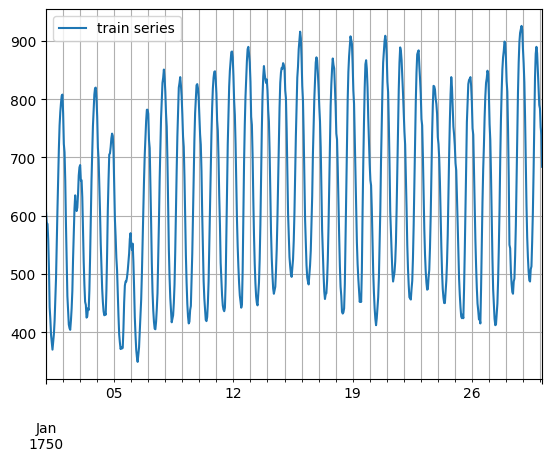

In [6]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

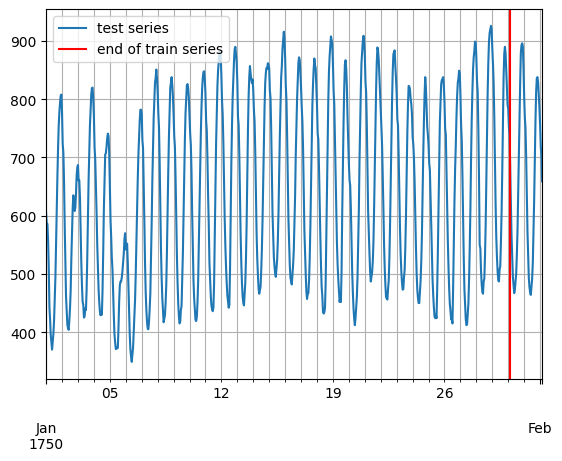

In [7]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color="r")  # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [8]:
from gluonts.mx import SimpleFeedForwardEstimator, Trainer

estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1e-3, num_batches_per_epoch=100),
)

In [9]:
from gluonts.evaluation import make_evaluation_predictions

predictor = estimator.train(dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

100%|██████████| 100/100 [00:01<00:00, 70.54it/s, epoch=5/5, avg_epoch_loss=4.76]


In [10]:
forecasts = list(forecast_it)
tss = list(ts_it)

KeyboardInterrupt: 

In [16]:
ts_entry = tss[0]
forecast_entry = forecasts[0]

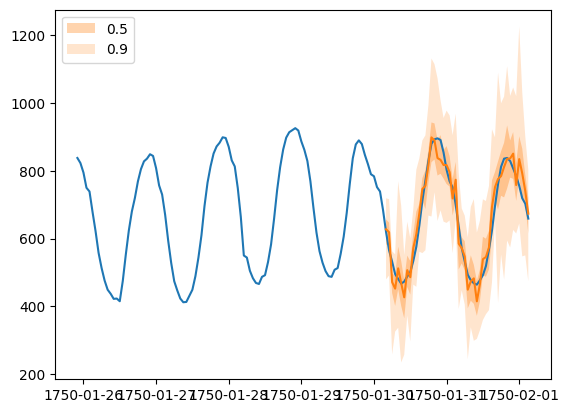

In [17]:
plt.plot(ts_entry[-150:].to_timestamp())
forecast_entry.plot(show_label=True)
plt.legend()

/home/plealm/Documentos/Unal/Maestria/1_Semestre/Series_Temporales/codigo/acciones/.venv/lib/python3.11/site-packages/gluonts/dataset/common.py:255: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ProcessDataEntry(to_offset(freq), one_dim_target, use_timestamp),
/home/plealm/Documentos/Unal/Maestria/1_Semestre/Series_Temporales/codigo/acciones/.venv/lib/python3.11/site-packages/gluonts/time_feature/lag.py:104: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = to_offset(freq_str)
/home/plealm/Documentos/Unal/Maestria/1_Semestre/Series_Temporales/codigo/acciones/.venv/lib/python3.11/site-packages/gluonts/time_feature/_base.py:249: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = to_offset(freq_str)


100%|██████████| 100/100 [00:02<00:00, 33.61it/s, epoch=50/50, avg_epoch_loss=1.74]
/home/plealm/Documentos/Unal/Maestria/1_Semestre/Series_Temporales/codigo/acciones/.venv/lib/python3.11/site-packages/gluonts/dataset/common.py:255: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ProcessDataEntry(to_offset(freq), one_dim_target, use_timestamp),


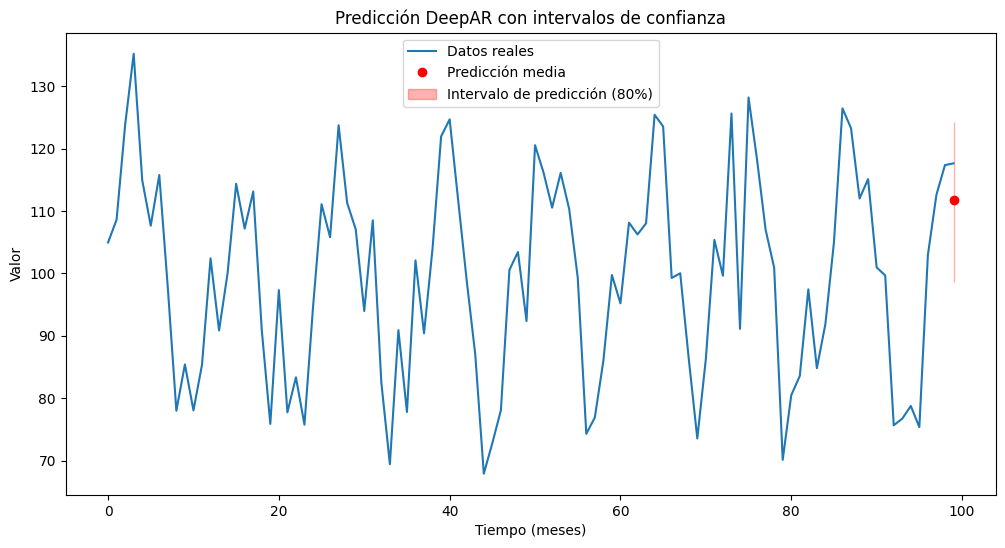

Predicción media: 111.74
Intervalo de predicción (80%): [98.69, 124.24]


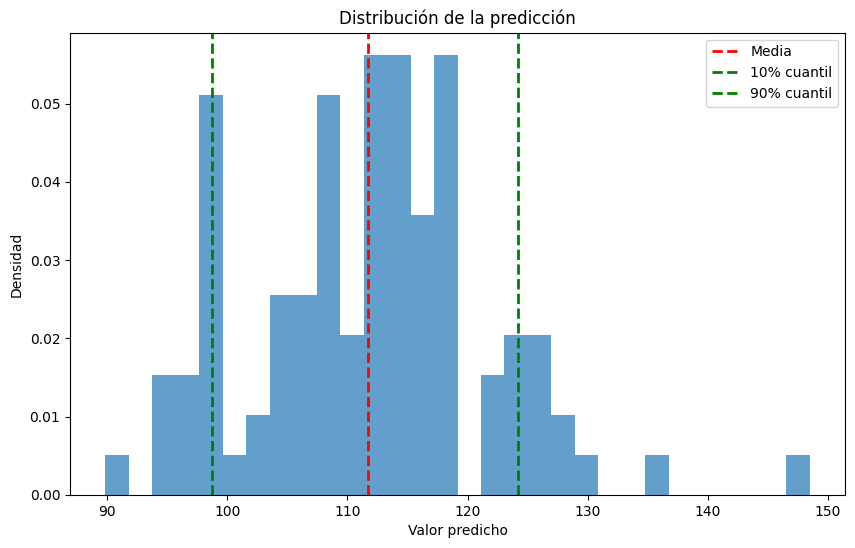

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mxnet as mx
from gluonts.dataset.common import ListDataset
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
# Configurar semilla para reproducibilidad
np.random.seed(42)
mx.random.seed(42)
# Generar serie de tiempo simulada
start_date = pd.Timestamp("2019-01-01")
num_samples = 100
time_series = np.random.normal(loc=100, scale=10, size=num_samples) + \
              np.sin(np.arange(num_samples) * 2 * np.pi / 12) * 20  # Patrón anual
# Crear dataset
train_ds = ListDataset(
    [{"start": start_date, "target": time_series[:-1]}],
    freq="M"
)
# Configurar y entrenar el modelo DeepAR
estimator = DeepAREstimator(
    freq="M",
    prediction_length=1,
    trainer=Trainer(epochs=50, num_batches_per_epoch=100)
)
predictor = estimator.train(train_ds)
# Realizar predicciones
forecast_it, ts_it = make_evaluation_predictions(
    dataset=ListDataset(
        [{"start": start_date, "target": time_series}],
        freq="M"
    ),
    predictor=predictor,
    num_samples=100
)
forecasts = list(forecast_it)
tss = list(ts_it)
# Extraer la media y los intervalos de confianza
mean_forecast = forecasts[0].mean
lower_quantiles = forecasts[0].quantile(0.1)
upper_quantiles = forecasts[0].quantile(0.9)
# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Datos reales')
plt.plot(range(num_samples-1, num_samples), mean_forecast, 'ro', label='Predicción media')
plt.fill_between([num_samples-1], lower_quantiles, upper_quantiles, color='r', alpha=0.3, label='Intervalo de predicción (80%)')
plt.legend()
plt.title('Predicción DeepAR con intervalos de confianza')
plt.xlabel('Tiempo (meses)')
plt.ylabel('Valor')
plt.show()
# Mostrar predicción probabilística
print(f"Predicción media: {mean_forecast[0]:.2f}")
print(f"Intervalo de predicción (80%): [{lower_quantiles[0]:.2f}, {upper_quantiles[0]:.2f}]")
# Histograma de las muestras de predicción
samples = forecasts[0].samples
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=30, density=True, alpha=0.7)
plt.axvline(mean_forecast[0], color='r', linestyle='dashed', linewidth=2, label='Media')
plt.axvline(lower_quantiles[0], color='g', linestyle='dashed', linewidth=2, label='10% cuantil')
plt.axvline(upper_quantiles[0], color='g', linestyle='dashed', linewidth=2, label='90% cuantil')
plt.title('Distribución de la predicción')
plt.xlabel('Valor predicho')
plt.ylabel('Densidad')
plt.legend()
plt.show()

/home/plealm/Documentos/Unal/Maestria/1_Semestre/Series_Temporales/codigo/acciones/.venv/lib/python3.11/site-packages/gluonts/dataset/common.py:255: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ProcessDataEntry(to_offset(freq), one_dim_target, use_timestamp),
/home/plealm/Documentos/Unal/Maestria/1_Semestre/Series_Temporales/codigo/acciones/.venv/lib/python3.11/site-packages/gluonts/time_feature/lag.py:104: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = to_offset(freq_str)
/home/plealm/Documentos/Unal/Maestria/1_Semestre/Series_Temporales/codigo/acciones/.venv/lib/python3.11/site-packages/gluonts/time_feature/_base.py:249: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = to_offset(freq_str)
  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:04<00:00, 21.63it/s, epoch=50/50, avg_epoch_loss=1.89]
/home/plealm/Documentos/Unal/Maestria/1_Semestre/Series_Temporales/codigo/acciones/.venv/lib/python3.11/site-packages/gluonts/dataset/common.py:255: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ProcessDataEntry(to_offset(freq), one_dim_target, use_timestamp),


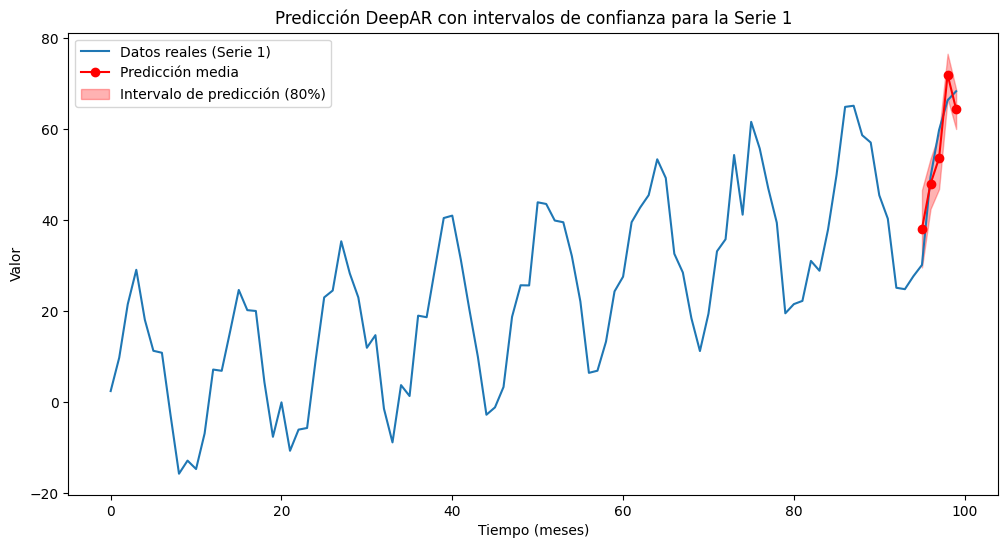

Predicciones para la Serie 1:
Paso 1:
  Predicción media: 38.15
  Intervalo de predicción (80%): [29.64, 46.64]
Paso 2:
  Predicción media: 48.00
  Intervalo de predicción (80%): [42.48, 53.50]
Paso 3:
  Predicción media: 53.64
  Intervalo de predicción (80%): [46.84, 58.98]
Paso 4:
  Predicción media: 71.98
  Intervalo de predicción (80%): [66.76, 76.57]
Paso 5:
  Predicción media: 64.38
  Intervalo de predicción (80%): [60.04, 68.72]


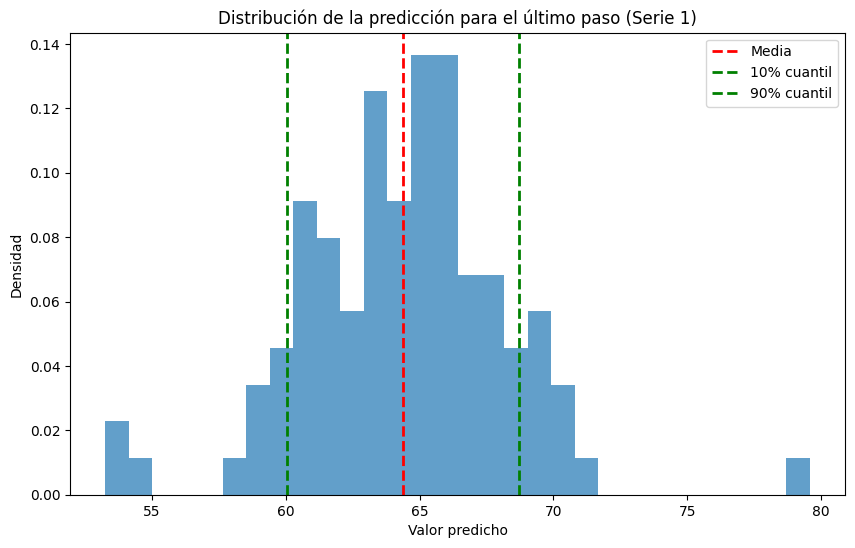

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mxnet as mx
from gluonts.dataset.common import ListDataset
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions

# Configurar semilla para reproducibilidad
np.random.seed(42)
mx.random.seed(42)

# Generar tres series de tiempo simuladas
start_date = pd.Timestamp("2019-01-01")
num_samples = 100

# Serie 1: Tendencia lineal + patrón anual + ruido
time_series1 = np.arange(num_samples) * 0.5 + \
               np.sin(np.arange(num_samples) * 2 * np.pi / 12) * 20 + \
               np.random.normal(loc=0, scale=5, size=num_samples)

# Serie 2: Patrón estacional + ruido
time_series2 = np.sin(np.arange(num_samples) * 2 * np.pi / 6) * 30 + \
               np.random.normal(loc=100, scale=10, size=num_samples)

# Serie 3: Tendencia exponencial + ruido
time_series3 = np.exp(np.arange(num_samples) * 0.03) + \
               np.random.normal(loc=0, scale=3, size=num_samples)

# Crear dataset
train_ds = ListDataset(
    [
        {"start": start_date, "target": time_series1[:-5]},
        {"start": start_date, "target": time_series2[:-5]},
        {"start": start_date, "target": time_series3[:-5]}
    ],
    freq="M"
)

# Configurar y entrenar el modelo DeepAR
estimator = DeepAREstimator(
    freq="M",
    prediction_length=10,
    trainer=Trainer(epochs=50, num_batches_per_epoch=100)
)
predictor = estimator.train(train_ds)

# Realizar predicciones para la primera serie
forecast_it, ts_it = make_evaluation_predictions(
    dataset=ListDataset(
        [{"start": start_date, "target": time_series1}],
        freq="M"
    ),
    predictor=predictor,
    num_samples=100
)

forecasts = list(forecast_it)
tss = list(ts_it)

# Extraer la media y los intervalos de confianza
mean_forecast = forecasts[0].mean
lower_quantiles = forecasts[0].quantile(0.1)
upper_quantiles = forecasts[0].quantile(0.9)

# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(time_series1, label='Datos reales (Serie 1)')
plt.plot(range(num_samples-5, num_samples), mean_forecast, 'ro-', label='Predicción media')
plt.fill_between(range(num_samples-5, num_samples), lower_quantiles, upper_quantiles, color='r', alpha=0.3, label='Intervalo de predicción (80%)')
plt.legend()
plt.title('Predicción DeepAR con intervalos de confianza para la Serie 1')
plt.xlabel('Tiempo (meses)')
plt.ylabel('Valor')
plt.show()

# Mostrar predicción probabilística
print("Predicciones para la Serie 1:")
for i in range(5):
    print(f"Paso {i+1}:")
    print(f"  Predicción media: {mean_forecast[i]:.2f}")
    print(f"  Intervalo de predicción (80%): [{lower_quantiles[i]:.2f}, {upper_quantiles[i]:.2f}]")

# Histograma de las muestras de predicción para el último paso
samples = forecasts[0].samples[:, -1]
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=30, density=True, alpha=0.7)
plt.axvline(mean_forecast[-1], color='r', linestyle='dashed', linewidth=2, label='Media')
plt.axvline(lower_quantiles[-1], color='g', linestyle='dashed', linewidth=2, label='10% cuantil')
plt.axvline(upper_quantiles[-1], color='g', linestyle='dashed', linewidth=2, label='90% cuantil')
plt.title('Distribución de la predicción para el último paso (Serie 1)')
plt.xlabel('Valor predicho')
plt.ylabel('Densidad')
plt.legend()
plt.show()

/tmp/ipykernel_48730/617140798.py:34: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start=start_date, periods=num_samples, freq='M')


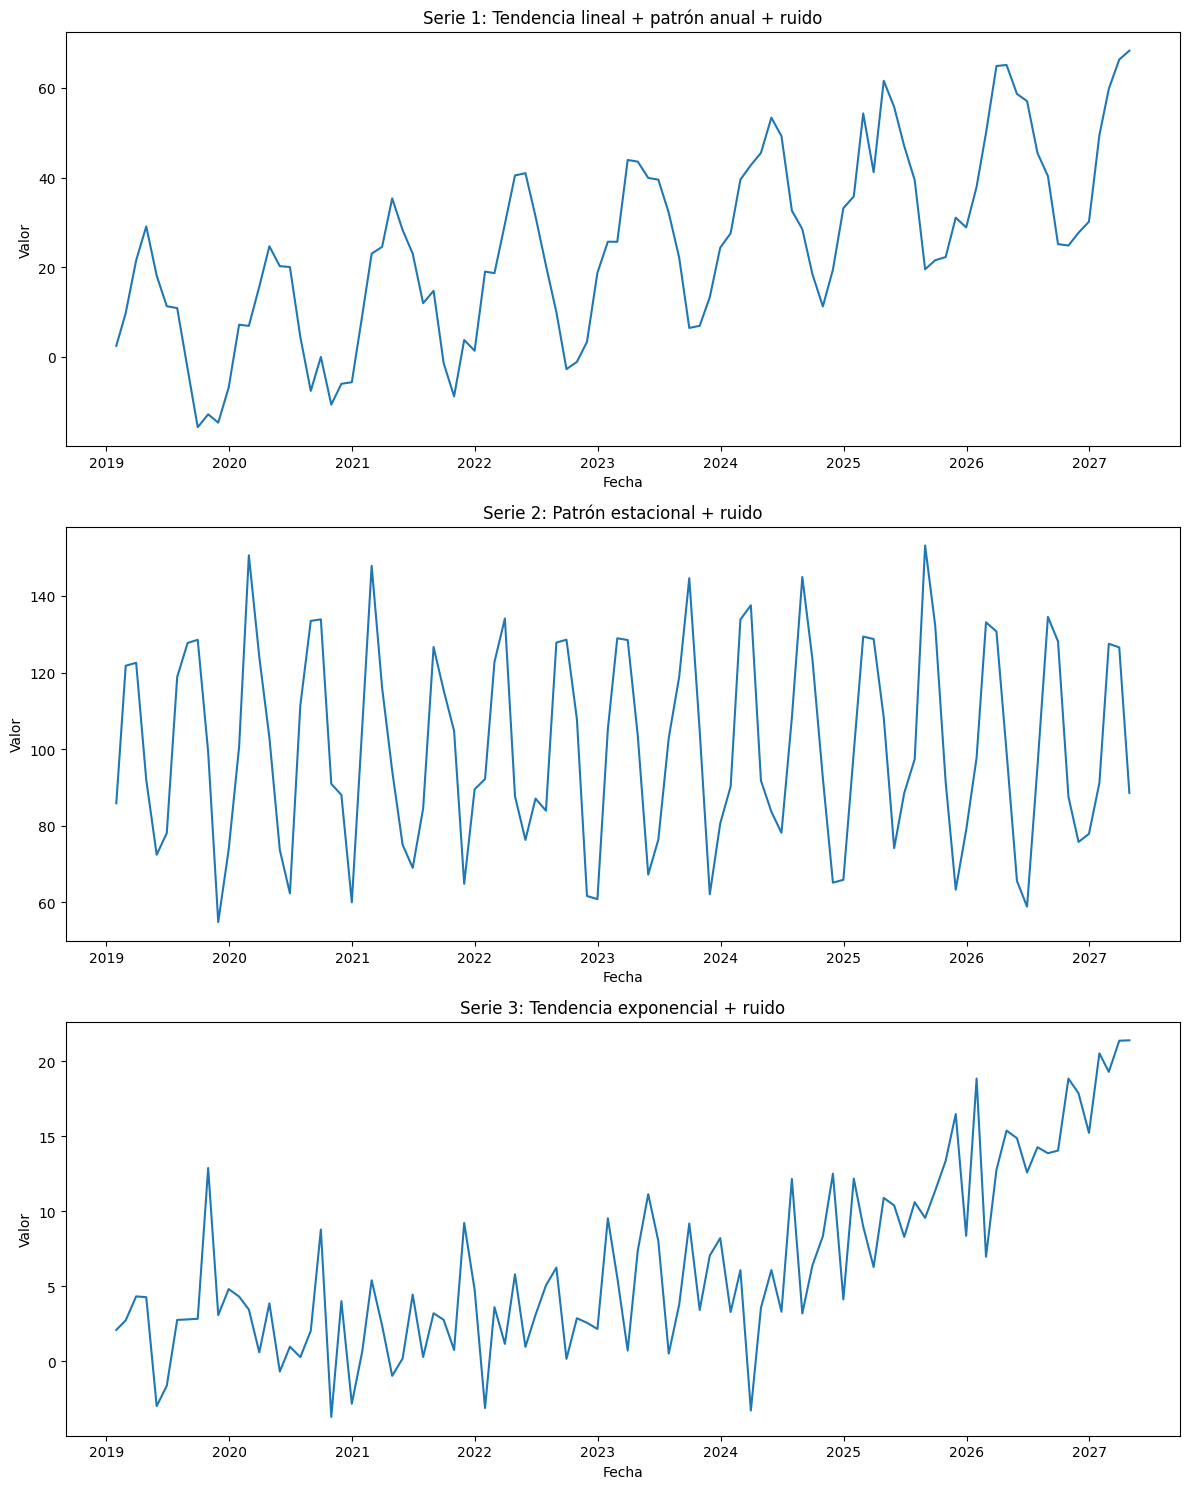

/home/plealm/Documentos/Unal/Maestria/1_Semestre/Series_Temporales/codigo/acciones/.venv/lib/python3.11/site-packages/gluonts/dataset/common.py:255: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ProcessDataEntry(to_offset(freq), one_dim_target, use_timestamp),
/home/plealm/Documentos/Unal/Maestria/1_Semestre/Series_Temporales/codigo/acciones/.venv/lib/python3.11/site-packages/gluonts/time_feature/lag.py:104: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = to_offset(freq_str)
/home/plealm/Documentos/Unal/Maestria/1_Semestre/Series_Temporales/codigo/acciones/.venv/lib/python3.11/site-packages/gluonts/time_feature/_base.py:249: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = to_offset(freq_str)
100%|██████████| 100/100 [00:02<00:00, 37.88it/s, epoch=50/50, avg_epoch_loss=1.89]
/home/plealm/Documentos/Unal/Maestri

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mxnet as mx
from gluonts.dataset.common import ListDataset
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from typing import Optional, Any

# Configurar semilla para reproducibilidad
np.random.seed(42)
mx.random.seed(42)

# Generar tres series de tiempo simuladas
start_date = pd.Timestamp("2019-01-01")
num_samples = 100

# Serie 1: Tendencia lineal + patrón anual + ruido
time_series1 = np.arange(num_samples) * 0.5 + \
               np.sin(np.arange(num_samples) * 2 * np.pi / 12) * 20 + \
               np.random.normal(loc=0, scale=5, size=num_samples)

# Serie 2: Patrón estacional + ruido
time_series2 = np.sin(np.arange(num_samples) * 2 * np.pi / 6) * 30 + \
               np.random.normal(loc=100, scale=10, size=num_samples)

# Serie 3: Tendencia exponencial + ruido
time_series3 = np.exp(np.arange(num_samples) * 0.03) + \
               np.random.normal(loc=0, scale=3, size=num_samples)

# Graficar cada una de las series de entrada
fig, axs = plt.subplots(3, 1, figsize=(12, 15))
dates = pd.date_range(start=start_date, periods=num_samples, freq='M')

axs[0].plot(dates, time_series1)
axs[0].set_title('Serie 1: Tendencia lineal + patrón anual + ruido')
axs[0].set_xlabel('Fecha')
axs[0].set_ylabel('Valor')

axs[1].plot(dates, time_series2)
axs[1].set_title('Serie 2: Patrón estacional + ruido')
axs[1].set_xlabel('Fecha')
axs[1].set_ylabel('Valor')

axs[2].plot(dates, time_series3)
axs[2].set_title('Serie 3: Tendencia exponencial + ruido')
axs[2].set_xlabel('Fecha')
axs[2].set_ylabel('Valor')

plt.tight_layout()
plt.show()

# Crear dataset
train_ds = ListDataset(
    [
        {"start": start_date, "target": time_series1[:-5]},
        {"start": start_date, "target": time_series2[:-5]},
        {"start": start_date, "target": time_series3[:-5]}
    ],
    freq="M"
)

# Configurar y entrenar el modelo DeepAR
estimator = DeepAREstimator(
    freq="M",
    prediction_length=5,
    trainer=Trainer(epochs=50, num_batches_per_epoch=100)
)
predictor = estimator.train(train_ds)

# Realizar predicciones para la primera serie
forecast_it, ts_it = make_evaluation_predictions(
    dataset=ListDataset(
        [{"start": start_date, "target": time_series1}],
        freq="M"
    ),
    predictor=predictor,
    num_samples=100
)

forecasts = list(forecast_it)
tss = list(ts_it)


# Preparar los datos de prueba
test_data = pd.Series(time_series1[-5:], index=pd.date_range(start=start_date + pd.Timedelta(days=95), periods=5, freq='M'))


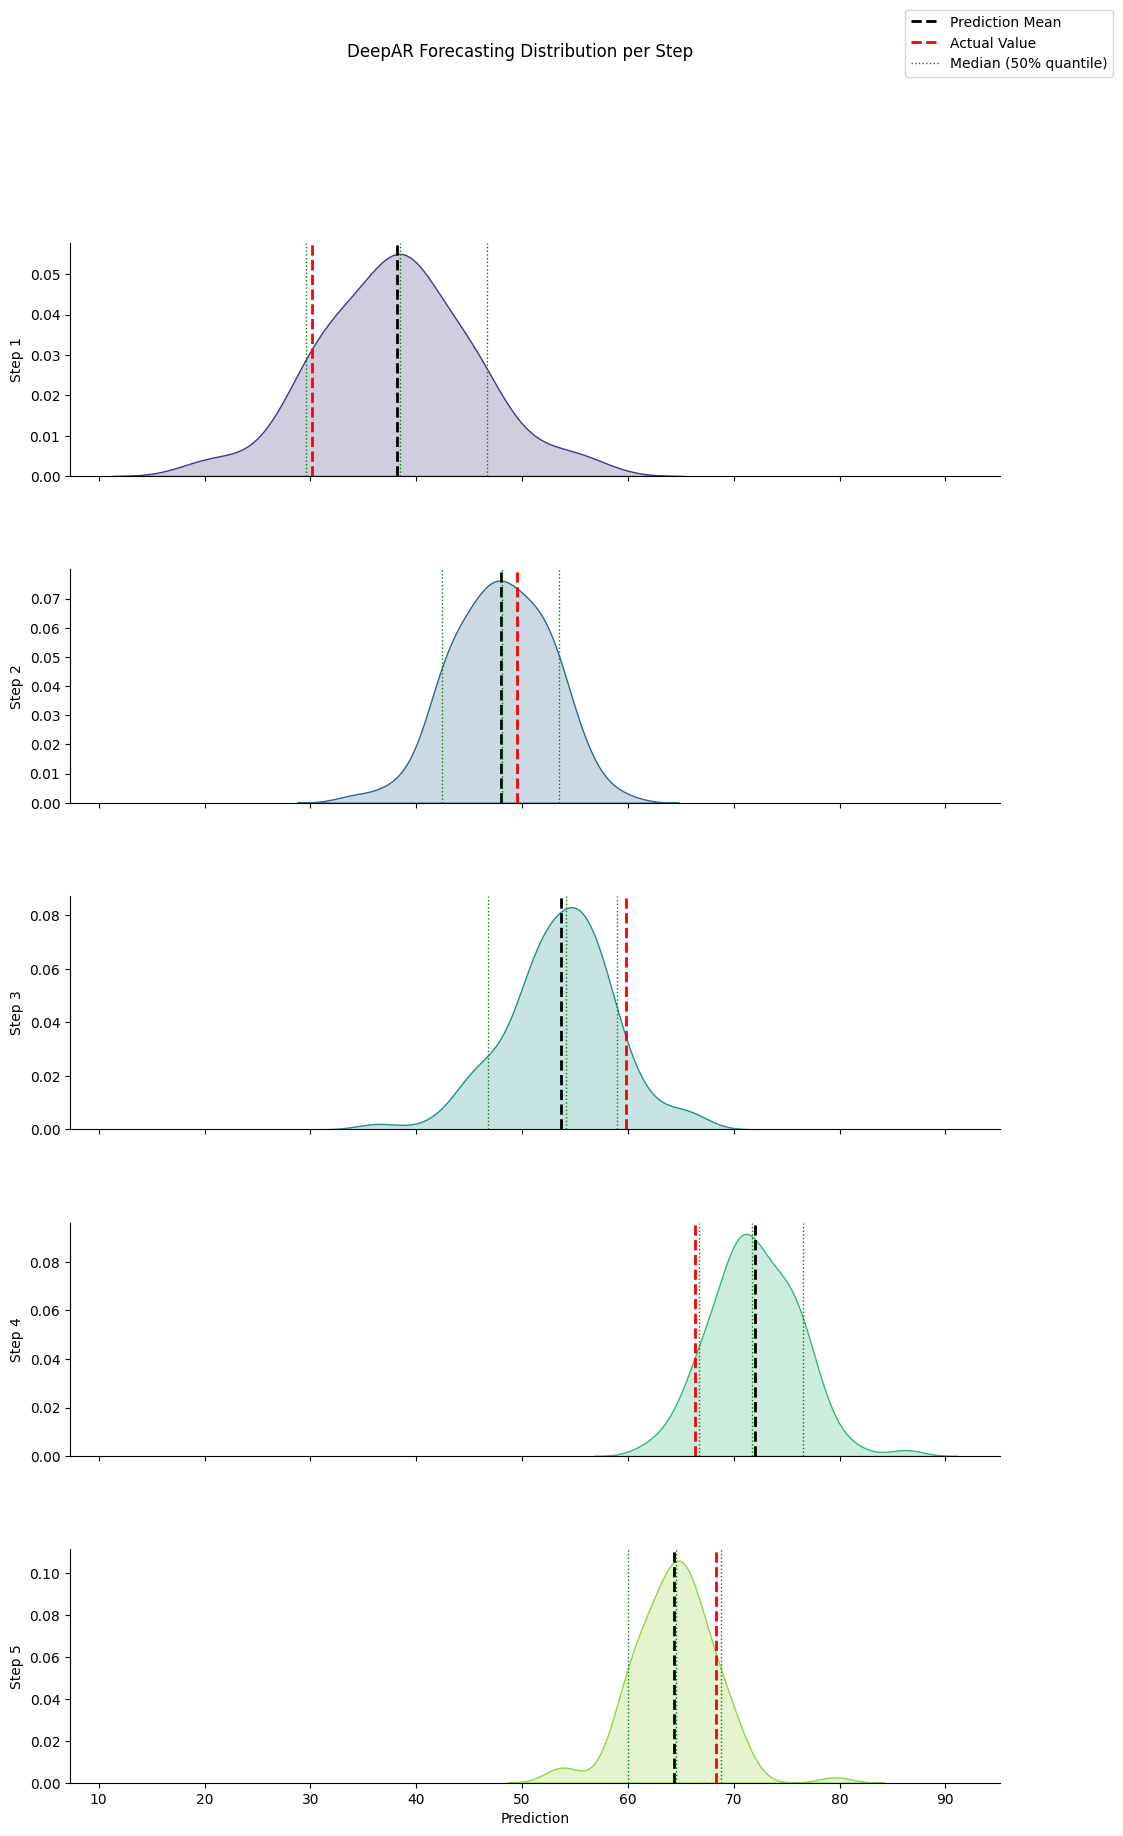

Resumen de predicciones:

Paso 1:
  Valor real: 30.18
  Predicción media: 38.15
  Predicción mediana: 38.43
  Intervalo de predicción (80%): [29.64, 46.64]

Paso 2:
  Valor real: 49.48
  Predicción media: 48.00
  Predicción mediana: 48.26
  Intervalo de predicción (80%): [42.48, 53.50]

Paso 3:
  Valor real: 59.81
  Predicción media: 53.64
  Predicción mediana: 54.22
  Intervalo de predicción (80%): [46.84, 58.98]

Paso 4:
  Valor real: 66.35
  Predicción media: 71.98
  Predicción mediana: 71.86
  Intervalo de predicción (80%): [66.76, 76.57]

Paso 5:
  Valor real: 68.33
  Predicción media: 64.38
  Predicción mediana: 64.79
  Intervalo de predicción (80%): [60.04, 68.72]


In [13]:
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_prediction_distribution(forecast, test_data: pd.Series, bw_method: Optional[Any] = None, **fig_kw) -> plt.Figure:
    samples = forecast.samples
    prediction_length = samples.shape[1]
    
    # Remove figsize from fig_kw if it's there, otherwise use a default
    figsize = fig_kw.pop('figsize', (12, 4*prediction_length))
    
    fig, axs = plt.subplots(prediction_length, 1, figsize=figsize, sharex=True, **fig_kw)
    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])
    
    palette = sns.color_palette("viridis", prediction_length)
    
    legend_handles = []
    legend_labels = []
    
    for i in range(prediction_length):
        step_samples = samples[:, i]
        
        # Use Seaborn's KDE plot
        sns.kdeplot(data=step_samples, ax=axs[i], fill=True, color=palette[i])
        
        prediction_mean = np.mean(step_samples)
        mean_line = axs[i].axvline(x=prediction_mean, color='black', linestyle='--', linewidth=2)
        
        # Add quantile lines
        quantiles = [0.1, 0.5, 0.9]
        quantile_values = np.quantile(step_samples, quantiles)
        quantile_lines = [axs[i].axvline(x=q, color='green', linestyle=':', linewidth=1) for q in quantile_values]
        
        real_value = test_data.iloc[i]
        actual_line = axs[i].axvline(x=real_value, color='red', linestyle='--', linewidth=2)
        
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].set_ylabel(f'Step {i+1}')
        axs[i].set_xlabel('Prediction')
        
        if i == 0:
            legend_handles.extend([mean_line, actual_line, quantile_lines[1]])
            legend_labels.extend(['Prediction Mean', 'Actual Value', 'Median (50% quantile)'])
    
    fig.subplots_adjust(hspace=0.4)
    fig.suptitle("DeepAR Forecasting Distribution per Step")
    
    fig.legend(legend_handles, legend_labels, loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=fig.transFigure)
    
    return fig

# Preparar los datos de prueba
test_data = pd.Series(time_series1[-5:], index=pd.date_range(start=start_date + pd.offsets.MonthEnd(95), periods=5, freq='ME'))

# Generar y mostrar el gráfico de distribución de predicciones
distribution_plot = plot_prediction_distribution(forecasts[0], test_data, figsize=(12, 20))
plt.show()

# Función para imprimir resumen numérico de predicciones
def print_prediction_summary(forecast, test_data):
    mean_forecast = forecast.mean
    median_forecast = forecast.quantile(0.5)
    lower_quantile = forecast.quantile(0.1)
    upper_quantile = forecast.quantile(0.9)
    
    print("Resumen de predicciones:")
    for i in range(len(mean_forecast)):
        print(f"\nPaso {i+1}:")
        print(f"  Valor real: {test_data.iloc[i]:.2f}")
        print(f"  Predicción media: {mean_forecast[i]:.2f}")
        print(f"  Predicción mediana: {median_forecast[i]:.2f}")
        print(f"  Intervalo de predicción (80%): [{lower_quantile[i]:.2f}, {upper_quantile[i]:.2f}]")

# Imprimir resumen de predicciones
print_prediction_summary(forecasts[0], test_data)

# Función para graficar valores reales vs predicciones


def plot_actual_vs_predicted(forecast, test_data, train_data):
    mean_forecast = forecast.mean
    lower_quantile = forecast.quantile(0.1)
    upper_quantile = forecast.quantile(0.9)
    
    # Combine train and test data
    full_data = pd.concat([train_data, test_data])
    
    # Create figure
    fig = make_subplots(specs=[[{"secondary_y": False}]])
    
    # Add traces for training data
    fig.add_trace(
        go.Scatter(x=train_data.index, y=train_data.values, name="Training Data", line=dict(color='blue'))
    )
    
    # Add traces for test data (actual values)
    fig.add_trace(
        go.Scatter(x=test_data.index, y=test_data.values, name="Actual", mode='lines+markers', marker=dict(color='red', size=8))
    )
    
    # Add traces for predicted values
    fig.add_trace(
        go.Scatter(x=test_data.index, y=mean_forecast, name="Predicted (mean)", mode='lines+markers', line=dict(color='green'))
    )
    
    # Add traces for prediction interval
    fig.add_trace(
        go.Scatter(
            x=test_data.index.tolist() + test_data.index[::-1].tolist(),
            y=upper_quantile.tolist() + lower_quantile[::-1].tolist(),
            fill='toself',
            fillcolor='rgba(0,100,80,0.2)',
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo="skip",
            showlegend=True,
            name="80% Prediction Interval"
        )
    )
    
    # Update layout
    fig.update_layout(
        title="Actual vs Predicted Values (with Training Data)",
        xaxis_title="Date",
        yaxis_title="Value",
        legend_title="Legend",
        hovermode="x unified"
    )
    
    # Show the plot
    fig.show()

train_data = pd.Series(time_series1[:-5], index=pd.date_range(start=start_date, periods=len(time_series1)-5, freq='ME'))

# Now call the function with train_data included
plot_actual_vs_predicted(forecasts[0], test_data, train_data)

In [39]:
forecasts[0].samples.shape

(100, 5)

In [25]:
train_data.index[-5]

Timestamp('2026-07-31 00:00:00')

In [27]:
test_data.index

DatetimeIndex(['2026-07-31', '2026-08-31', '2026-09-30', '2026-10-31',
               '2026-11-30'],
              dtype='datetime64[ns]', freq='ME')